In [28]:
from transformers import BertTokenizer
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from transformers import BertModel
from transformers import BertForSequenceClassification
from torch.optim import Adam
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmetrics


In [30]:
raw_data = pd.read_csv("/kaggle/input/natural-disaster/train.csv")
raw_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


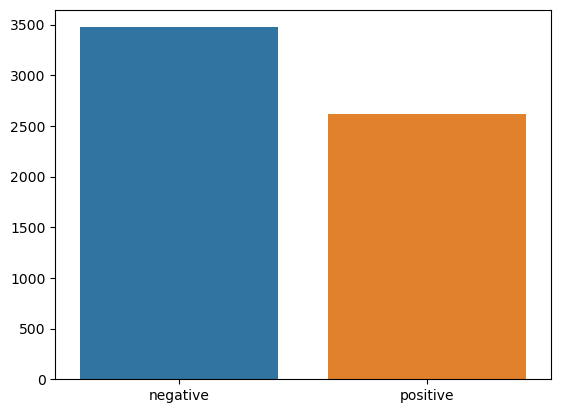

In [93]:
dd = pd.Series(df_train.target).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()   # Количество негативных на треть больше позитивных

In [88]:
# Делаю простое кодирование - нумерацию, смотрю корреляцию:
raw_data.apply(lambda x: x.factorize()[0]).corr()

# keyword, location не кореллируют с таргетом - можно пренебречь

,id,keyword,location,text,target
id,1.000000,0.976664,0.396733,0.998358,-0.060789
keyword,0.976664,1.000000,0.407958,0.977283,-0.047721
location,0.396733,0.407958,1.000000,0.397693,0.025229
text,0.998358,0.977283,0.397693,1.000000,-0.058769
target,-0.060789,-0.047721,0.025229,-0.058769,1.000000


In [31]:
# Слишком много уникальных локаций, влияние на модель низкое.
len(raw_data.location.unique())

3342

In [37]:
# Делю выборку на train, val, test
np.random.seed(1)

df_train, df_val, df_test = np.split(raw_data.sample(frac=1, random_state=42),
                                    [int(.8*len(raw_data)), int(.9*len(raw_data))])

print(len(df_train), len(df_val), len(df_test))

6090 761 762


# Baseline-модель
Для сравнения модели с использованием трансформеров, создам простую baseline модель на лог. регрессии с tf-idf.

In [66]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression())
])

In [67]:
pipeline.fit(df_train["text"], df_train["target"])
best_predictions = pipeline.predict(df_test["text"])

In [68]:
print("Baseline accuracy:", skmetrics.accuracy_score(best_predictions, df_test["target"]))
print("Precision", skmetrics.precision_score(best_predictions, df_test["target"]))
print("Recall", skmetrics.recall_score(best_predictions, df_test["target"]))
print("F1 Score:", skmetrics.f1_score(best_predictions, df_test["target"]))

Baseline accuracy: 0.8057742782152231
Precision 0.7026239067055393
Recall 0.8397212543554007
F1 Score: 0.765079365079365


# Классификатор на Bert

In [69]:
BERT_PRETRAINED = "bert-base-uncased"

In [70]:
tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED)

In [71]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = df['target'].to_list()
        self.texts = [tokenizer(text, 
                               padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [72]:
# Класс модели для обучения.
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.7):
        
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)

        self.relu = nn.ReLU()
        
    def forward(self, input_id, mask):
        
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)

        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        
        return final_layer

In [80]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")  
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
        
    for epoch_num in range(epochs):
        total_accuracy_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            accuracy = (output.argmax(dim=1) == train_label).sum().item()
            total_accuracy_train += accuracy
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_accuracy_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                
                val_label = val_label.to(device)

                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label.long())

                total_loss_val += batch_loss.item()
                
                accuracy = (output.argmax(dim=1) == val_label).sum().item()
                total_accuracy_val += accuracy
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_accuracy_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_accuracy_val / len(val_data): .3f}')
            

In [81]:
EPOCHS = 4
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 381/381 [09:10<00:00,  1.44s/it]


Epochs: 1 | Train Loss:  0.082                 | Train Accuracy:  0.457                 | Val Loss:  0.060                 | Val Accuracy:  0.619


100%|██████████| 381/381 [09:04<00:00,  1.43s/it]


Epochs: 2 | Train Loss:  0.050                 | Train Accuracy:  0.688                 | Val Loss:  0.044                 | Val Accuracy:  0.748


100%|██████████| 381/381 [08:51<00:00,  1.39s/it]


Epochs: 3 | Train Loss:  0.039                 | Train Accuracy:  0.773                 | Val Loss:  0.038                 | Val Accuracy:  0.769


100%|██████████| 381/381 [08:51<00:00,  1.39s/it]


Epochs: 4 | Train Loss:  0.033                 | Train Accuracy:  0.811                 | Val Loss:  0.033                 | Val Accuracy:  0.802


In [104]:
# Метод для получения предсказаний модели на данных
def get_predictions(model, data_df):
    test_data = Dataset(data_df)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=2)
    
    model.eval()
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")  
    
    predictions = []
    with torch.no_grad():
        for test_input, test_label in test_loader:
            test_label = test_label.to(device)
    
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
                    
            output = model(input_id, mask).argmax(dim=1)
            predictions.append(output.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [105]:
predictions = get_predictions(model, df_test)

In [85]:
print("Bert-based-model accuracy:", skmetrics.accuracy_score(predictions, df_test["target"]))
print("Precision", skmetrics.precision_score(predictions, df_test["target"]))
print("Recall", skmetrics.recall_score(predictions, df_test["target"]))
print("F1 Score:", skmetrics.f1_score(predictions, df_test["target"]))

Bert-based-model accuracy: 0.8162729658792651
Precision 0.7638483965014577
Recall 0.8161993769470405
F1 Score: 0.7891566265060241


## Запись в файл

In [97]:
test_data = pd.read_csv("/kaggle/input/natural-disaster/test.csv")

In [112]:
model.eval()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")  

test_text_list = [tokenizer(text, 
                            padding='max_length', 
                            max_length = 512, 
                            truncation=True,
                            return_tensors="pt") for text in test_data["text"]]

test_predictions = []

for test_text in test_text_list:
    mask = test_text['attention_mask'].to(device)
    input_id = test_text['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask).argmax(dim=1)
    test_predictions.append(output.cpu().numpy())
    
output = np.concatenate(test_predictions, axis=0)

In [116]:
test_data["prediction"] = output

In [117]:
test_data.to_csv("test_output.csv", index=False)